# Classification by logistic regression

Parameters have been extracted from the images and are going to be implemented into a clustering algorithm.

The images were skeletonised and a voronoi diagram was made using the branch points. Then parameters from the cells in the voronoi diagram were extracted.

Nodes: number of connecting branches
Verticies: number of points
Angular defect: 
iscoperimetric: ratio proportional to the area/perimeter^2
Number of polygons:
Average number of sides per polygon:

This notebook was made following the tutorial on the tensorflow website
https://www.tensorflow.org/guide/core/logistic_regression_core

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.11.0


### Prepare the data

In [2]:
# load data
data = pd.read_csv("voronoi_parameters/test.txt", sep=',', header=[0])

# remove names
files = data.loc[:, "file"] 
data = data.drop("file", axis=1)

In [3]:
# change all -1 values to 0 (for normalisation)
data = data.replace(-1, 0)
#for index in range(len(data.columns)):
    #data.iloc[:, index] = data.iloc[:, index]/data.iloc[:, index].max() #normalise betwenn 0 and 1


In [4]:
conc_class = []
for index in range(len(data)):
    image = files.iloc[index]
    
    if ('OA' in image) or ('OB' in image) or ('OC' in image):
        conc_class.append("low")
    elif ('OD' in image) or ('OE' in image) or ('OF' in image):
        conc_class.append("high")
        
labeled_data = data
labeled_data["conc"] = conc_class

In [5]:
labeled_data.head()

,node,verticies,defect,ratio,# of polygons,# of sides,conc
0,135,416,0.035832,0.607405,75,5.546667,low
1,5,16,0.000000,0.088624,5,3.200000,low
2,0,0,0.000000,0.000000,0,0.000000,low
3,16,50,0.000000,0.530207,11,4.545455,low
4,14,44,0.000000,0.516043,10,4.400000,low


In [6]:
train_data = labeled_data.sample(frac=0.75, random_state=1)
#train_data['class'] = train_data['class'].astype('object')
print(len(train_data))
test_data = labeled_data.drop(train_data.index)
print(len(test_data))

#train_data.rename(index={6: "conc"})
print(train_data.columns)
train_data.dtypes

32
10
Index([' node', ' verticies', ' defect', ' ratio', ' # of polygons',
       ' # of sides', 'conc'],
      dtype='object')


 node               int64
 verticies          int64
 defect           float64
 ratio            float64
 # of polygons      int64
 # of sides       float64
conc               object
dtype: object

In [7]:
y_train = train_data["conc"]
x_train = train_data.drop("conc", axis=1) # axis=1 specifies to drop the column
y_test = test_data["conc"]
x_test = test_data.drop("conc", axis=1)

y_train, y_test = y_train.map({'low': 0, 'high': 1}), y_test.map({'low': 0, 'high': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

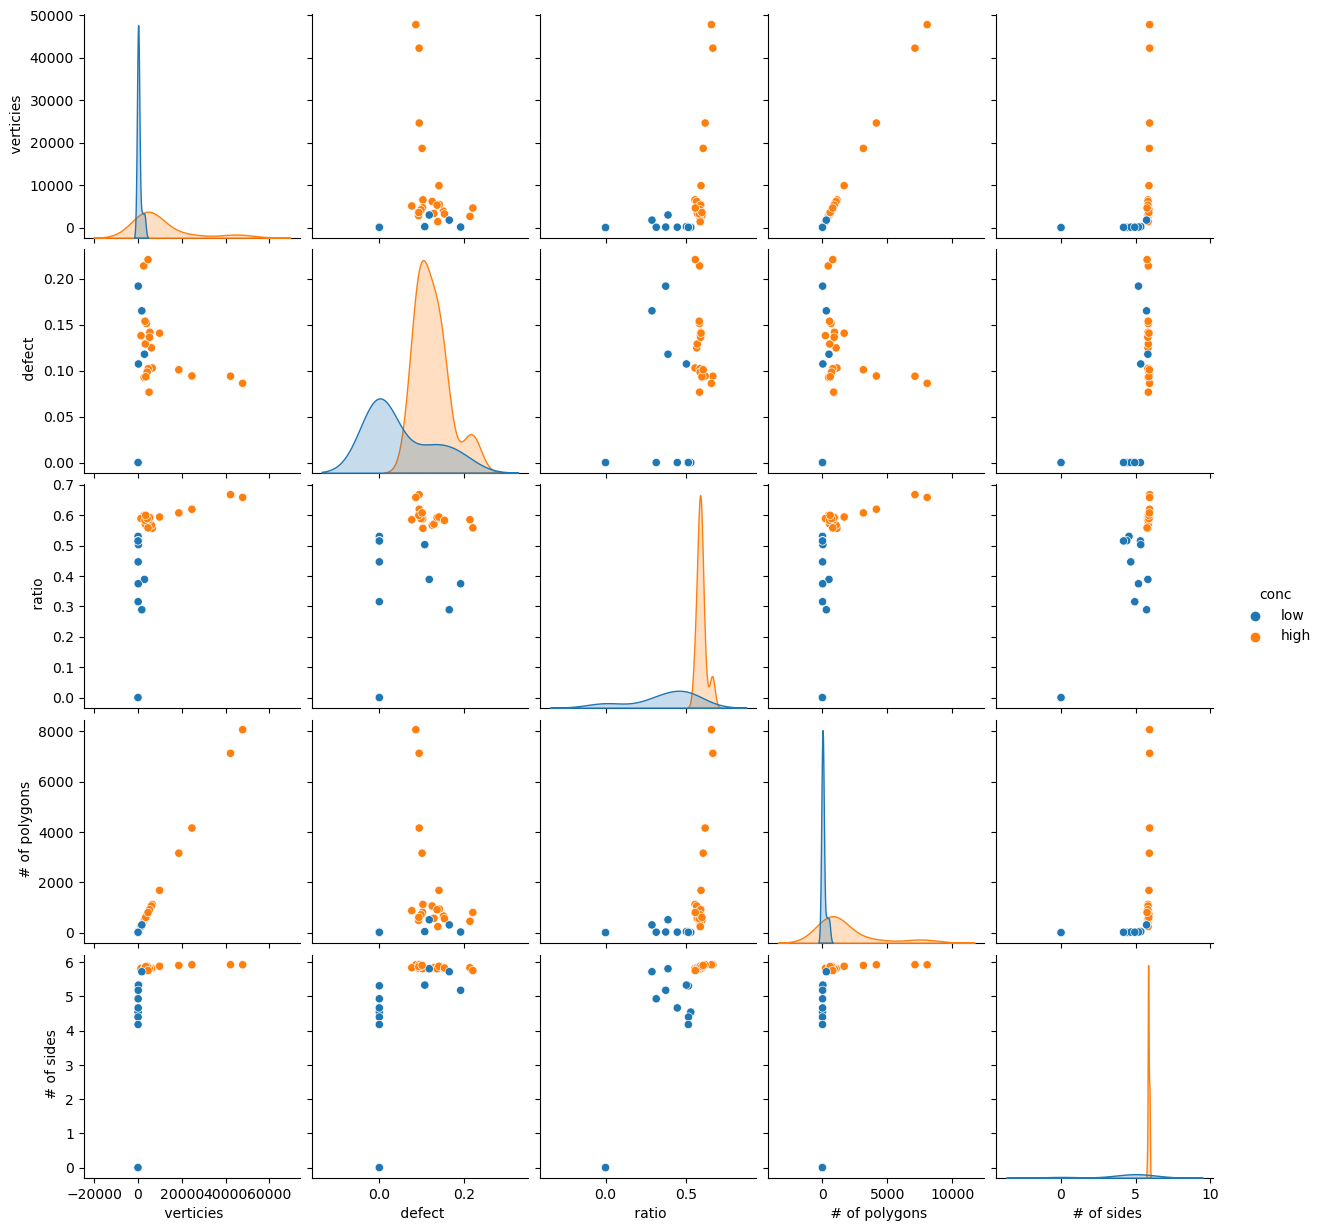

In [8]:
# iclude hue='class' not working to show different classes on the plots
sns.pairplot(train_data.iloc[:, 1:7], hue = "conc", diag_kind='kde');
plt.show()

In [9]:
train_data.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
node,32.0,2183.281250,3780.365311,0.0,50.500000,1076.000000,1745.750000,15848.000000
verticies,32.0,6607.562500,11405.756529,0.0,156.000000,3268.000000,5317.000000,47830.000000
defect,32.0,0.096019,0.065767,0.0,0.057415,0.101486,0.138684,0.220672
ratio,32.0,0.508706,0.160806,0.0,0.512077,0.576660,0.592322,0.667465
# of polygons,32.0,1122.375000,1922.604110,0.0,29.500000,560.000000,914.750000,8069.000000
# of sides,32.0,5.222363,1.456107,0.0,5.279829,5.818836,5.840390,5.930435


In [10]:
# make a class which allows the data to be normalised with a mean 0 and var 1
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)    
    

## Logistic regression

Maps the outputs of linear regression $(-\inf, \inf)$ to probabilities $(0, 1)$. This is symmetric so flipping the output signs form linear regression results in inverse of probability.

### Activation function

The sigmoid function will be used to determine the probability $Y = \frac{e^z}{1 + e^{-z}}$ where $z = wx +b$. 

This can be written as a matrix equation as $ Y = \sigma (wX +b)$.

Where $Y$ is the target vector (the labels).

$X$ is a matrix of features.

$w$ is a vector of weights for each feature.

$b$ is a bias.

$\sigma$ is a sigmoid function applies to each output of the matrix equation.

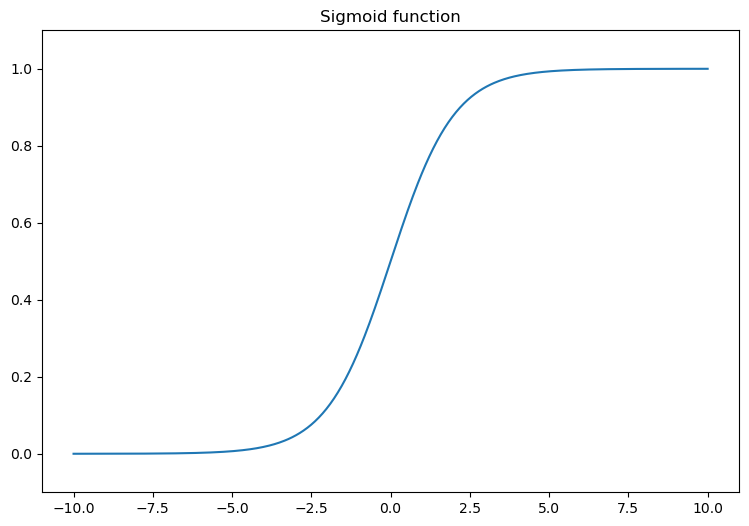

In [11]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");
plt.show()

### Loss/cost function

Use the log loss function/ binary cross-entropy loss (best loss function for binary classification with logistic regression according to tf site).

$L = -\frac{1}{m} \sum_i^m(y_i \times log(\hat{y}_i) + (1 + y_i) \times log(1-\hat{y}_i)$

Where $y_i$ is a vector of labels / targets.

$\hat{y}$ is a vector of predicted probabilities.

In [12]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

Use gradient descent to update the model in order to minimise the loss function

In [13]:
class LogisticRegression(tf.Module):
    def __init__(self):
        self.built = False
        
    def __call__(self, x, train = True):
        # initialise model params on first call
        if not self.built:
            # randomly generate weights and bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
             # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
          return z
        return tf.sigmoid(z)
                    

In [14]:
# make sure the model output values between 0 and 1 for a small subset of training data
# thich checks its working properly

log_reg = LogisticRegression()
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()


array([0.16159217, 0.00363964, 0.87036246, 0.80792   , 0.23688516],
      dtype=float32)

In [15]:
# write an accuracy function 
def predict_class(y_pred, thresh=0.5):
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    y_pred = tf.math.sigmoid(y_pred)
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y, tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

## Train the model

In [17]:
batch_size = 10
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)


In [19]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.351
Epoch: 20, Training log loss: 0.243
Epoch: 40, Training log loss: 0.223
Epoch: 60, Training log loss: 0.202
Epoch: 80, Training log loss: 0.210


## Evaluate performance

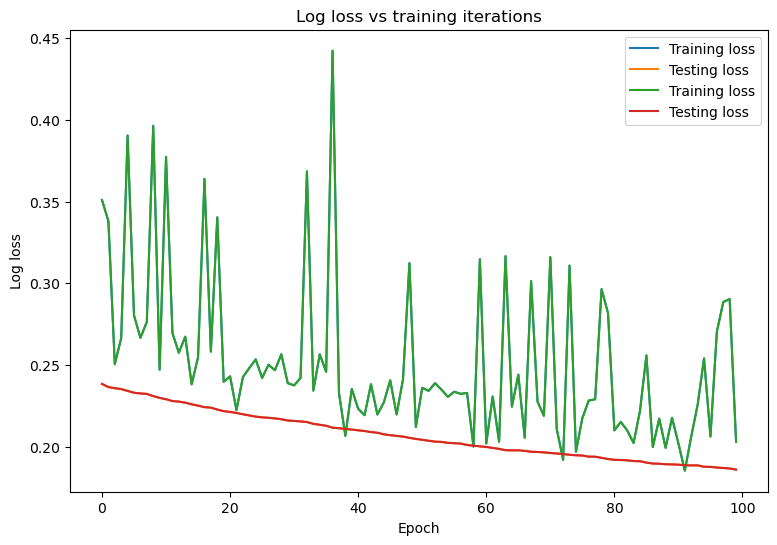

In [21]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");
plt.show()

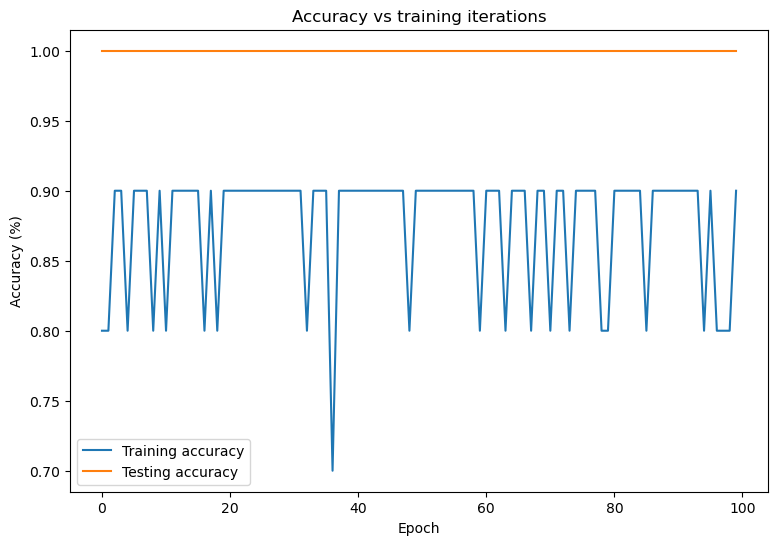

In [23]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");
plt.show()

In [24]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.203
Final testing log Loss: 0.186


In [25]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.900
Final testing accuracy: 1.000


In [30]:
def show_confusion_matrix(y, y_classes, typ):
    # Compute the confusion matrix and normalize it
    plt.figure(figsize=(10,10))
    confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1)
    axis_labels = range(2)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title(f"Confusion matrix: {typ}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)


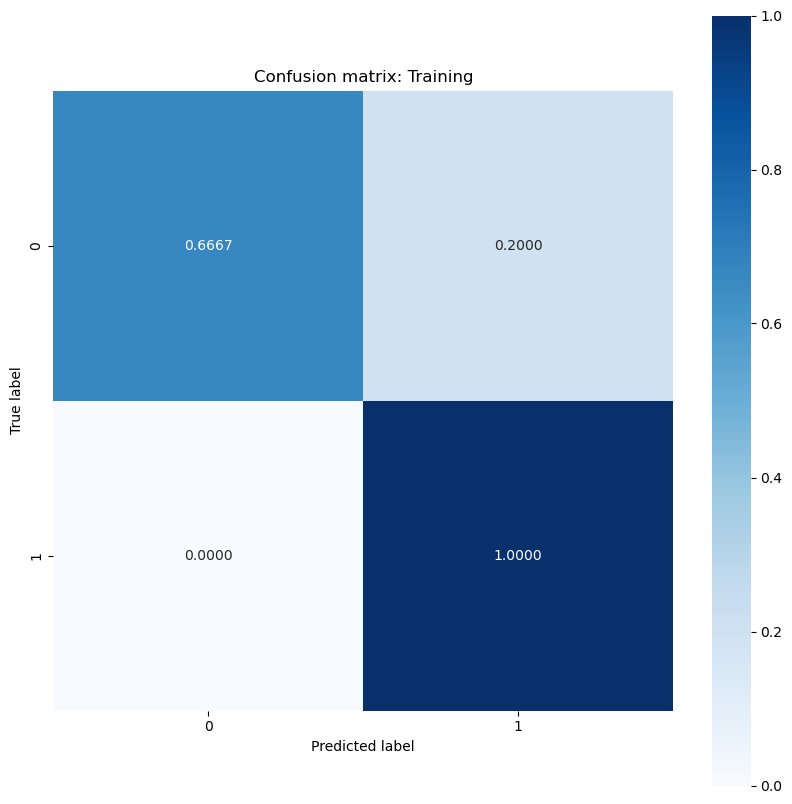

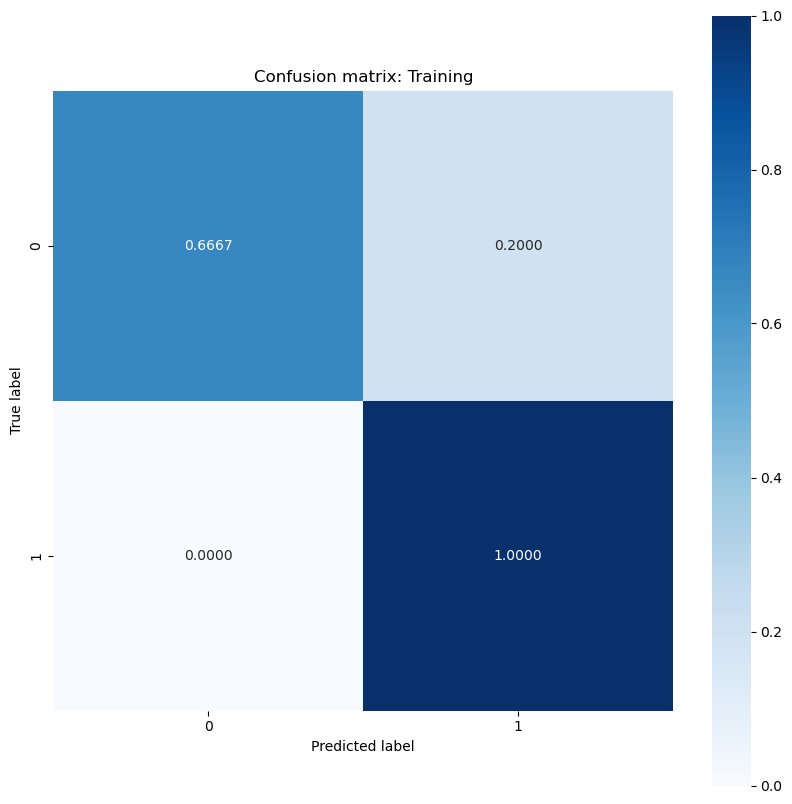

In [31]:
show_confusion_matrix(y_train, train_classes, 'Training')
plt.show()

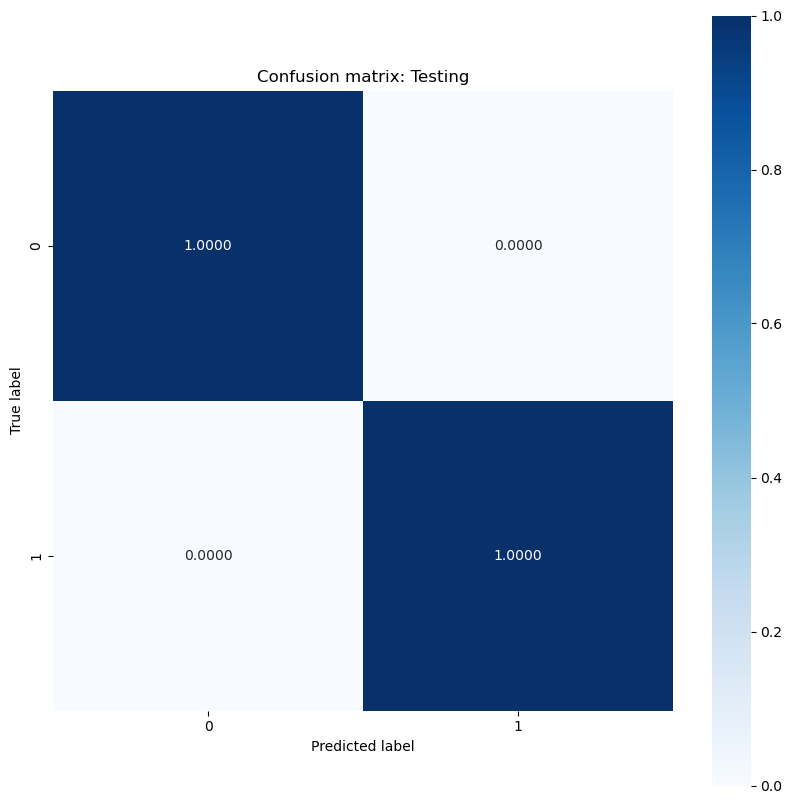

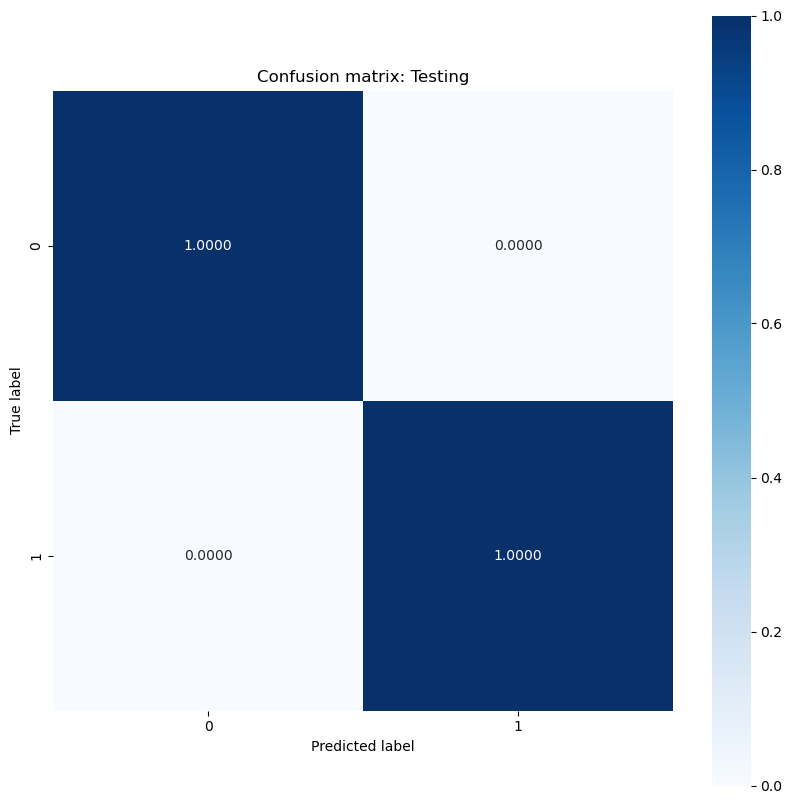

In [33]:
show_confusion_matrix(y_test, test_classes, 'Testing')
plt.show()